In [ ]:
#importing libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.applications import vgg16
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0


In [ ]:
#Extracting the contents from zip file
import zipfile
zip_ref = zipfile.ZipFile('content/lung-and-colon-cancer-histopathological-images.zip')
zip_ref.extractall('content')
zip_ref.close()

In [ ]:
DATADIR = 'content/lung_image_sets'
CATEGORIES = ['lung_aca', 'lung_n', 'lung_scc']

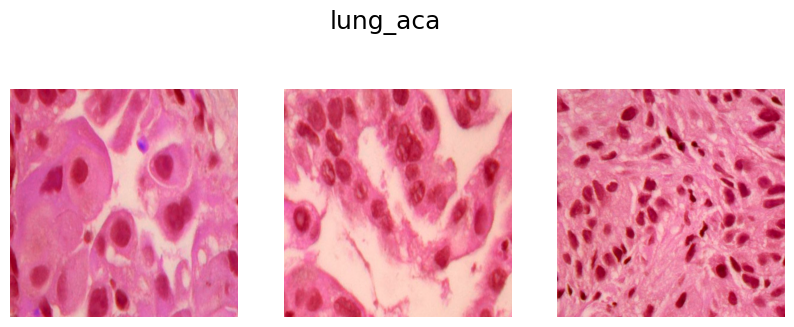

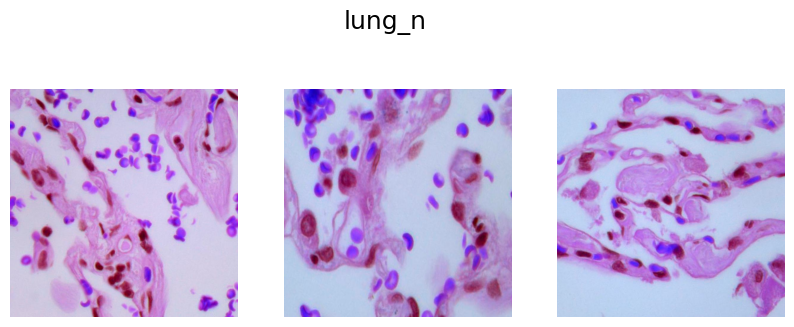

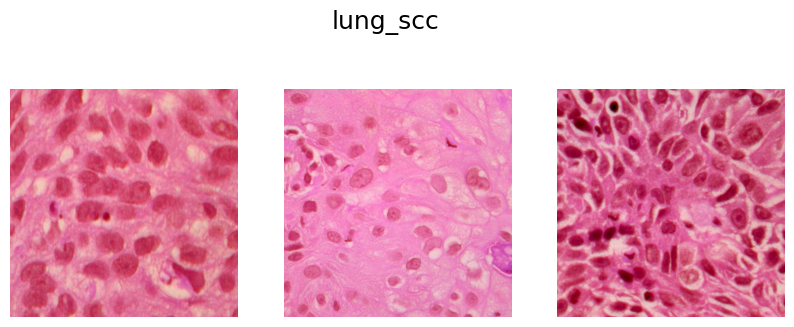

In [ ]:
# Displaying the images
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    images = os.listdir(path)

    # Initialize a subplot with 1 row and 3 columns
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle(f'{category}', fontsize=18)

    for i in range(3):
        # Randomly select an image
        img_name = images[np.random.randint(0, len(images))]
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path)

        # Display the image
        ax[i].imshow(img_array)
        ax[i].axis('off')


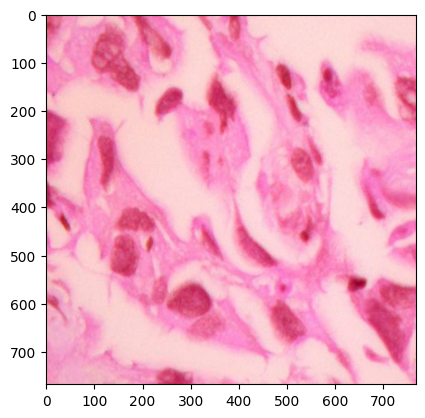

In [ ]:
for category in CATEGORIES:
  path = os.path.join(DATADIR, category)      #path to cats or dogs directory
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img))
    plt.imshow(img_array)
    plt.show()
    break
  break

In [ ]:
img_array.shape

(768, 768, 3)

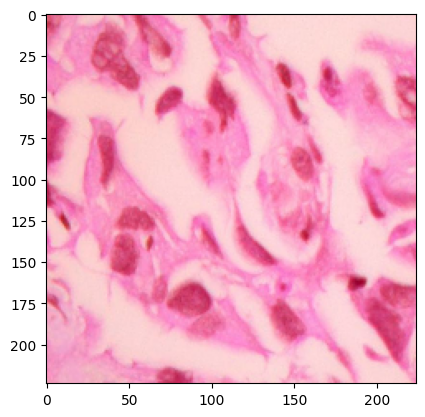

In [ ]:
IMG_SIZE = 224

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)

In [ ]:
new_array.shape

(224, 224, 3)

In [ ]:
# creating training data

training_data = []

def create_training_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        training_data.append([new_array, class_num])
      except Exception as e:
        pass

create_training_data()

In [ ]:
len(training_data)

15000

In [ ]:
X = []
y = []

for features, label in training_data:
  X.append(features)
  y.append(label)

In [ ]:
# Converting the data type of X and y from list to numpy array
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)    # last value '3' for 'RGB'
y = np.array(y)

In [ ]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size = 0.2,
                                                  random_state = 42)

In [ ]:
print(f'X_train Length : {X_train.shape[0]}, X_train Image size : {X_train.shape[1:3]}, Channel Dimension : {X_train.shape[3]}')
print(f'X_test Length : {X_test.shape[0]}, X_test Image size : {X_test.shape[1:3]}, Channel Dimension : {X_test.shape[3]}')

X_train Length : 12000, X_train Image size : (224, 224), Channel Dimension : 3
X_test Length : 3000, X_test Image size : (224, 224), Channel Dimension : 3


In [ ]:
# vgg model
vgg = vgg16.VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (IMG_SIZE, IMG_SIZE, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# freezing the bottom (conv) layers
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
# building the top (FC) layers
model = keras.Sequential([
    vgg,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(3, activation = 'softmax'),
])

In [ ]:
#compilation
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs = 5)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 154ms/step - accuracy: 0.9028 - loss: 0.7288
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 159ms/step - accuracy: 0.9760 - loss: 0.0589
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 86s 169ms/step - accuracy: 0.9817 - loss: 0.0540
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - accuracy: 0.9899 - loss: 0.0295
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 171ms/step - accuracy: 0.9892 - loss: 0.0284


In [ ]:
# evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 268ms/step - accuracy: 0.9876 - loss: 0.0401
Model Accuracy : 98.1333315372467


In [ ]:
# first 5 true labels
y_test[:5]

array([2, 1, 2, 0, 1])

In [ ]:
pred = np.argmax(model.predict(X_test), axis = -1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step


In [ ]:
# first 5 predicted labels
pred[:5]

array([2, 1, 2, 0, 1])

In [ ]:
# classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1037
           1       1.00      1.00      1.00       970
           2       0.99      0.95      0.97       993

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



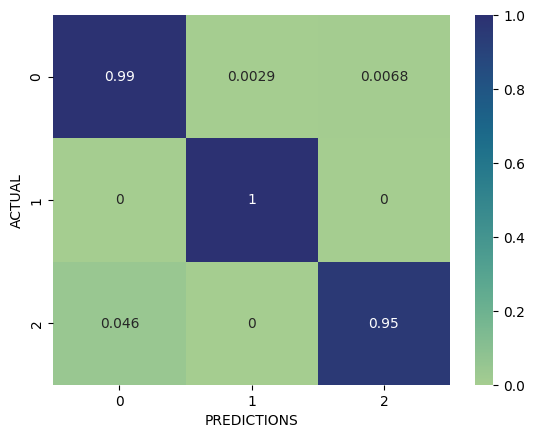

In [ ]:
#confusion matrix
cf = confusion_matrix(y_test, pred, normalize = 'true')
sns.heatmap(cf, annot = True, cmap = 'crest');
plt.xlabel('PREDICTIONS');
plt.ylabel('ACTUAL');

- 0 - lung_adenocarcinomas - Correct classification with 96% accuracy
- 1 - lung_normal - Correct classification with 100% accuracy
- 2 - lung_squamous_cell_carcinomas - Correct classification with 99% accuracy